[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aalhossary/pyemgpipeline/blob/master/docs/notebooks/ex3_DataProcessingManager.ipynb)

# Example 3 - High-level, guided processing (using gesture data)

This example shows the usage of class
[DataProcessingManager](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#dataprocessingmanager),
a high-level, guided processing interface with accepted EMG processing conventions.
This is the recommended way of EMG processing using this package.

The data used in this example contains two files of subject #10 in ["EMG data for gestures"](https://archive-beta.ics.uci.edu/ml/datasets/emg+data+for+gestures) from the UC Irvine Machine Learning Repository.
In particular, the data was collected in eight channels from the forearm of the subject while performing series of static hand gestures.

## Package preparation

We install and import needed packages.

In [1]:
!pip install pyemgpipeline -q

In [2]:
import os
import numpy as np
from matplotlib.figure import SubplotParams
import pyemgpipeline as pep

## Data preparation

First download the raw data from the UC Irvine Machine Learning Repository.

When finished, the compressed file "EMG_data_for_gestures-master.zip" (~17MB) is saved in the "uci_gestures" subfolder.

In [3]:
!rm -rf uci_gestures
!wget -q https://archive.ics.uci.edu/ml/machine-learning-databases/00481/EMG_data_for_gestures-master.zip -P ./uci_gestures

Uncompress the downloaded file. This example will only use two files of subject 10, which are in the archived folder "EMG_data_for_gestures-master/10". 

In [4]:
# !unzip -q uci_gestures/EMG_data_for_gestures-master.zip -d ./uci_gestures  #This command extracts all files.
!unzip -q uci_gestures/EMG_data_for_gestures-master.zip EMG_data_for_gestures-master/10/* -d ./uci_gestures  #This command extracts only the file needed in this example.

Signal data of each trial should be stored in a 2d ndarray with shape (*n_samples*, *n_channels*), where each column represents data of one channel.
Data of multiple trials are organized in a list.

First we set up basic information of the data, including data path, channel names, sample rate, etc.

In [5]:
data_folder = 'uci_gestures/EMG_data_for_gestures-master/10'
data_filenames = ['1_raw_data_11-08_21.03.16.txt', '2_raw_data_11-10_21.03.16.txt']
trial_names = ['trial 1', 'trial 2']
channel_names = ['channel1', 'channel2', 'channel3', 'channel4', 'channel5', 'channel6', 'channel7', 'channel8']
sample_rate = 1000

Signal data of multiple trials are stored in *all_data* of type list, where each element of the list is a 2d ndarray. Since the raw data provides the timestamp information, it is also extracted in *all_timestamp* of type list, where each element is a 1d ndarray.

In [6]:
all_timestamp = []
all_data = []
for fn in data_filenames:
    data = np.genfromtxt(os.path.join(data_folder, fn), delimiter='\t', skip_header=1)
    all_timestamp.append(data[:, 0] / sample_rate)
    all_data.append(data[:, 1:9])

In [7]:
all_timestamp

[array([1.0000e-03, 5.0000e-03, 6.0000e-03, ..., 6.4554e+01, 6.4555e+01,
        6.4557e+01]),
 array([1.0000e-03, 5.0000e-03, 6.0000e-03, ..., 6.3954e+01, 6.3955e+01,
        6.3956e+01])]

In [8]:
all_data

[array([[-2.e-05, -1.e-05, -3.e-05, ..., -1.e-05,  1.e-05,  1.e-05],
        [-2.e-05, -1.e-05, -3.e-05, ..., -1.e-05,  1.e-05,  1.e-05],
        [-2.e-05, -1.e-05, -3.e-05, ..., -1.e-05,  1.e-05,  1.e-05],
        ...,
        [ 0.e+00,  3.e-05,  4.e-05, ..., -3.e-05,  0.e+00,  0.e+00],
        [ 0.e+00,  3.e-05,  4.e-05, ..., -3.e-05,  0.e+00,  0.e+00],
        [ 0.e+00,  3.e-05,  4.e-05, ..., -3.e-05,  0.e+00,  0.e+00]]),
 array([[-2.e-05, -5.e-05, -4.e-05, ..., -2.e-05,  1.e-05,  0.e+00],
        [-2.e-05, -5.e-05, -4.e-05, ..., -2.e-05,  1.e-05,  0.e+00],
        [-2.e-05, -5.e-05, -4.e-05, ..., -2.e-05,  1.e-05,  0.e+00],
        ...,
        [ 1.e-05,  1.e-05,  0.e+00, ..., -1.e-05, -1.e-05, -1.e-05],
        [ 1.e-05,  2.e-05,  5.e-05, ..., -2.e-05, -1.e-05, -1.e-05],
        [ 1.e-05,  2.e-05,  5.e-05, ..., -2.e-05, -1.e-05, -1.e-05]])]

In [9]:
print('shapes of all_timestamp:', all_timestamp[0].shape, all_timestamp[1].shape)
print('shapes of all_data:', all_data[0].shape, all_data[1].shape)

shapes of all_timestamp: (61641,) (61448,)
shapes of all_data: (61641, 8) (61448, 8)


We also set up the parameters for plotting with an instance of class
[EMGPlotParams](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.plots.html#emgplotparams).
Note that the whole setting configures the plotting of a single trial. Plotting of all trials use the same setting.

In [10]:
emg_plot_params = pep.plots.EMGPlotParams(
    n_rows=2,
    n_cols=4,
    fig_kwargs={
        'figsize': (16, 3),
        'subplotpars': SubplotParams(top=0.8, wspace=0.1, hspace=0.4),
    }
)

## Data processing

First we create an instance of class
[DataProcessingManager](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#dataprocessingmanager).

In [11]:
mgr = pep.wrappers.DataProcessingManager()

We use method *set_data_and_params* to set or reset signal data *all_data*, timestamp data *all_timestamp*, and other information, to the data processing manager instance.

In [12]:
mgr.set_data_and_params(all_data, hz=sample_rate,
                        all_timestamp=all_timestamp, trial_names=trial_names,
                        channel_names=channel_names, emg_plot_params=emg_plot_params)

Note that the above method also initializes five processing steps as default in case they are not set yet. The steps can be examined as follows:

In [13]:
mgr.show_current_processes_and_related_params()

---- Current processes and related parameters ----
DC offset remover    : No parameters
Bandpass filter      : hz = 1000, bf_order = 4, bf_cutoff_fq_lo = 10, bf_cutoff_fq_hi = 450
Full wave rectifier  : No parameters
Linear envelope      : hz = 1000, le_order = 4, le_cutoff_fq = 6
End frame cutter     : n_end_frames = 30


The data processing manager instance contains instances of all processors (which can be None), including
[DCOffsetRemover](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#dcoffsetremover),
[BandpassFilter](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#bandpassfilter),
[FullWaveRectifier](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#fullwaverectifier),
[LinearEnvelope](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#linearenvelope),
[EndFrameCutter](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#endframecutter),
[AmplitudeNormalizer](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#amplitudenormalizer),
and
[Segmenter](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#segmenter).
All of them can be set or reset.

For example, we reset the
[BandpassFilter](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#bandpassfilter)
processor with different parameters and show current processes again.

In [14]:
mgr.set_bandpass_filter(pep.processors.BandpassFilter(hz=sample_rate, bf_order=4, bf_cutoff_fq_lo=5, bf_cutoff_fq_hi=470))
mgr.show_current_processes_and_related_params()

---- Current processes and related parameters ----
DC offset remover    : No parameters
Bandpass filter      : hz = 1000, bf_order = 4, bf_cutoff_fq_lo = 5, bf_cutoff_fq_hi = 470
Full wave rectifier  : No parameters
Linear envelope      : hz = 1000, le_order = 4, le_cutoff_fq = 6
End frame cutter     : n_end_frames = 30


We then set the
[AmplitudeNormalizer](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#amplitudenormalizer)
processor, which will calculate the maximum amplitude of each channel across trials for normalization.

In [15]:
mgr.set_amplitude_normalizer(pep.processors.AmplitudeNormalizer())
mgr.show_current_processes_and_related_params()

---- Current processes and related parameters ----
DC offset remover    : No parameters
Bandpass filter      : hz = 1000, bf_order = 4, bf_cutoff_fq_lo = 5, bf_cutoff_fq_hi = 470
Full wave rectifier  : No parameters
Linear envelope      : hz = 1000, le_order = 4, le_cutoff_fq = 6
End frame cutter     : n_end_frames = 30
Amplitude normalizer : No parameters


The *process_all* method is responsible for applying all processors in the predefined sequence. With the parameter *is_plot_processing_chain* being True, the original data and intermediate data after each step will be displayed.

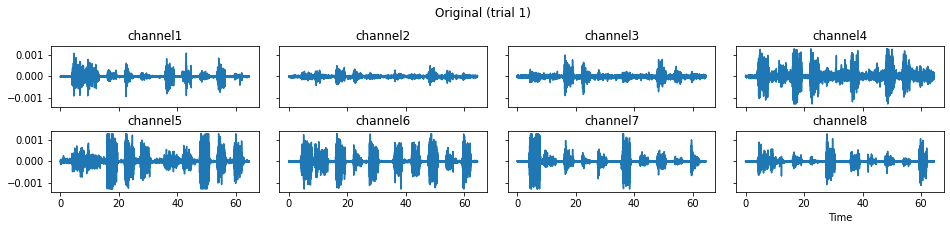

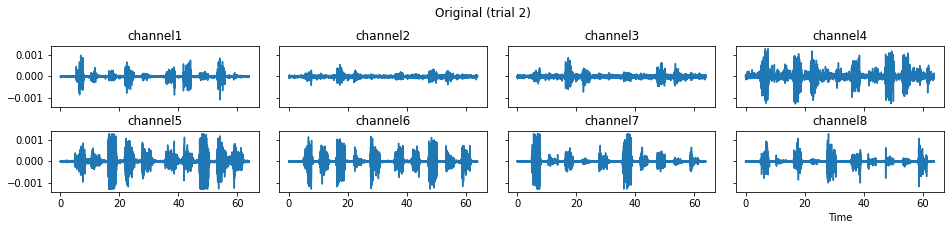

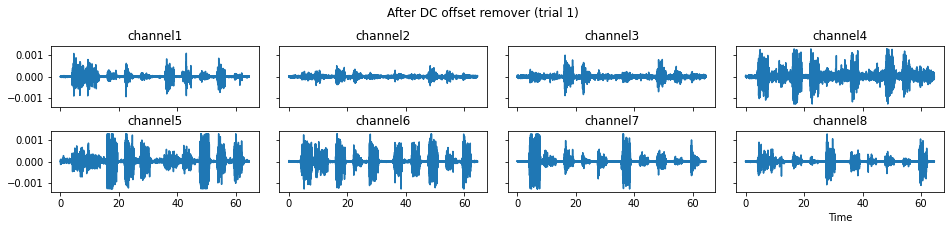

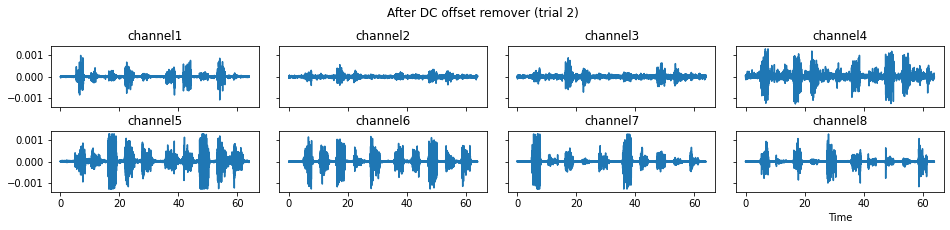

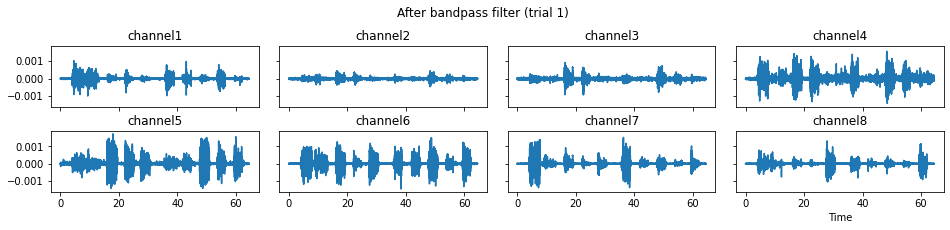

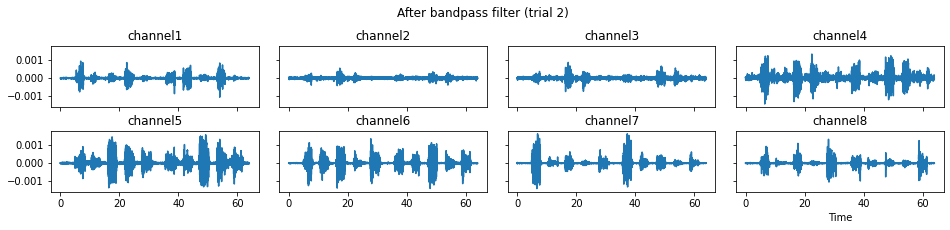

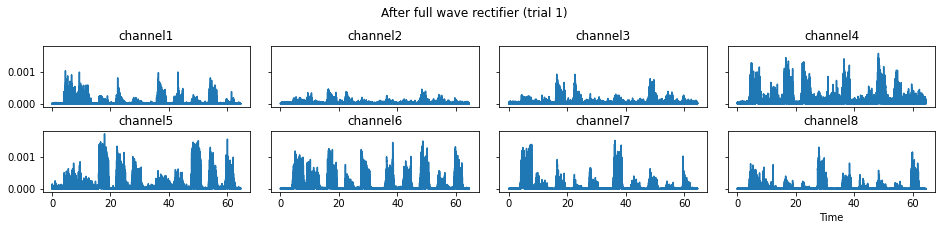

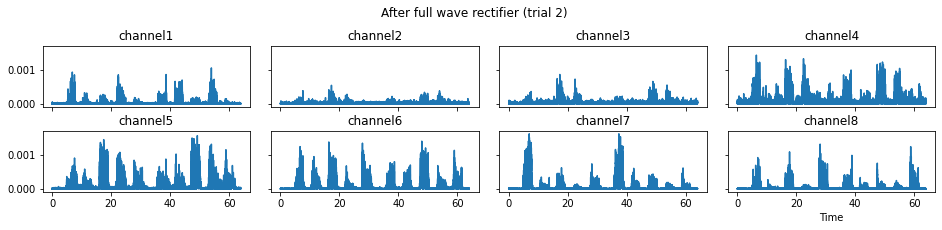

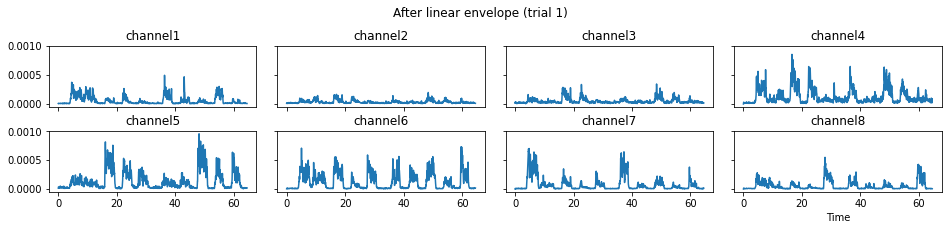

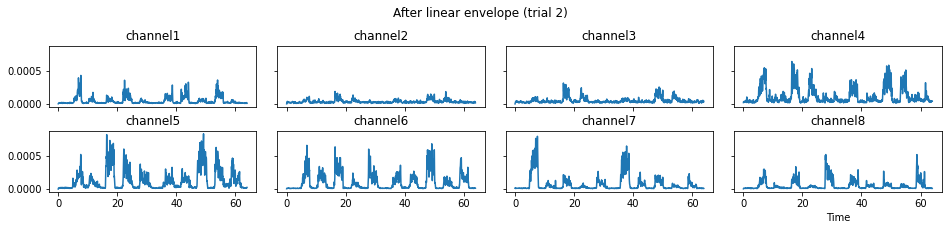

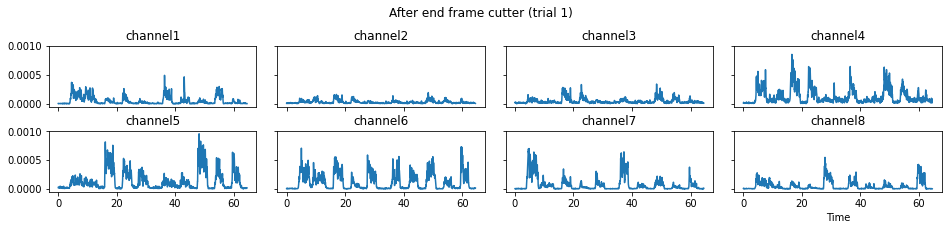

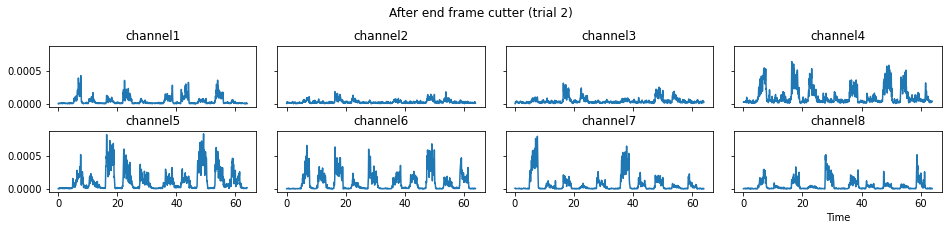

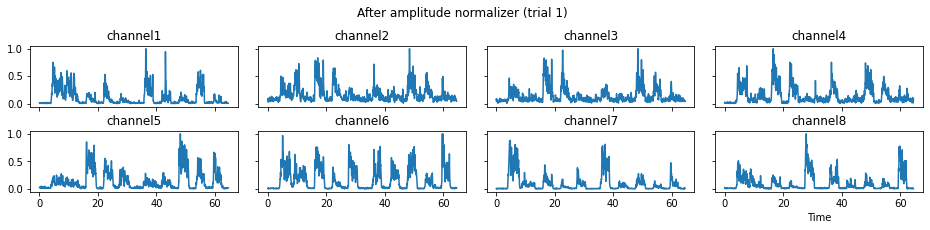

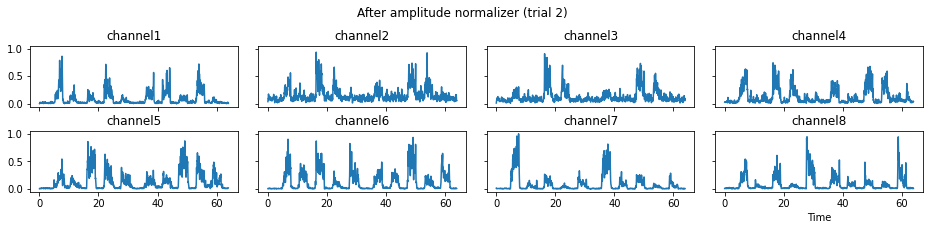

In [16]:
c = mgr.process_all(is_plot_processing_chain=True)

For demonstration purpose, assume the segment of interest of trial 2 is in the time range (15, 28). We can add the
[Segmenter](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.processors.html#segmenter)
processor and the time range to the data processing manager as the following.

In [17]:
all_beg_ts = [0, 15]
all_end_ts = [999, 28]
mgr.set_segmenter(pep.processors.Segmenter(), all_beg_ts, all_end_ts)
mgr.show_current_processes_and_related_params()

---- Current processes and related parameters ----
DC offset remover    : No parameters
Bandpass filter      : hz = 1000, bf_order = 4, bf_cutoff_fq_lo = 5, bf_cutoff_fq_hi = 470
Full wave rectifier  : No parameters
Linear envelope      : hz = 1000, le_order = 4, le_cutoff_fq = 6
End frame cutter     : n_end_frames = 30
Amplitude normalizer : No parameters
Segmenter            : No parameters


We now run the *process_all* method again with the updated processing steps. When *is_plot_processing_chain* is True, *k_for_plot=1* indicates that only trial index 1 (i.e., trial 2) will be plotted. The segmentation result is shown in the last part of the figures.

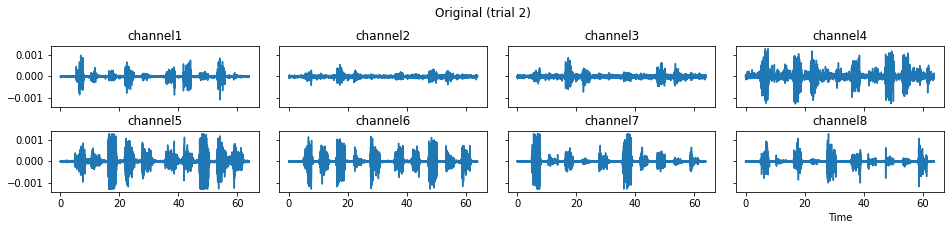

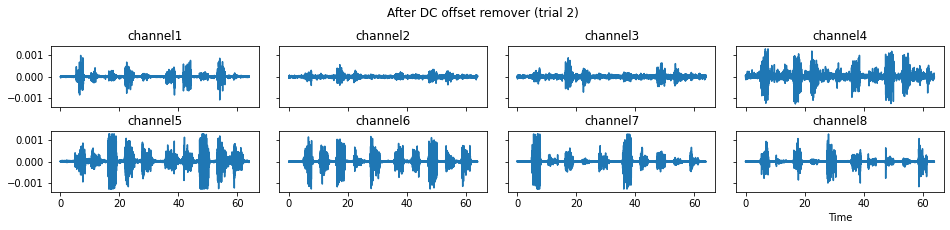

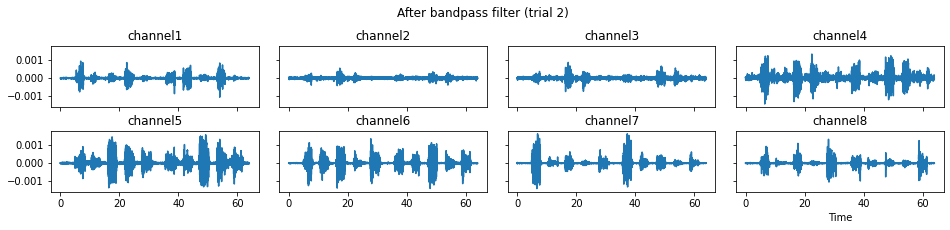

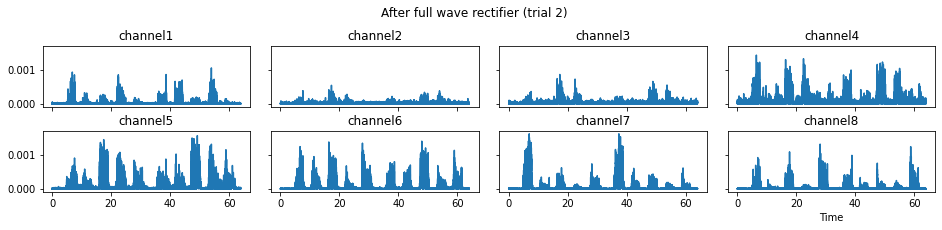

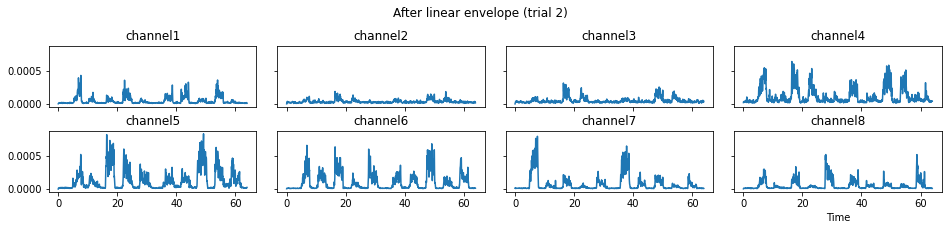

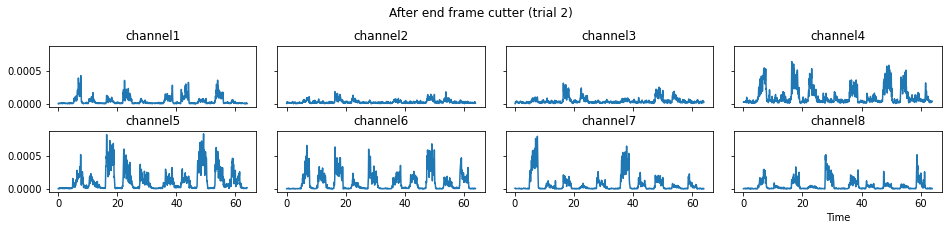

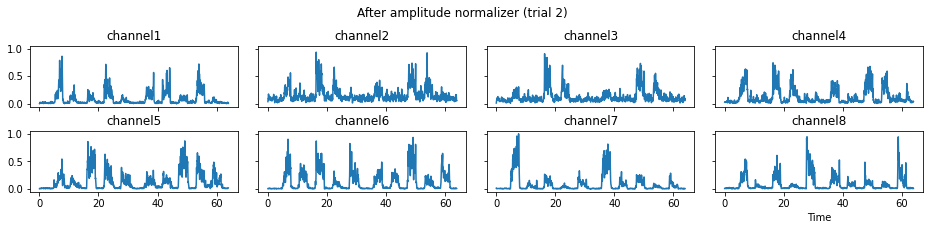

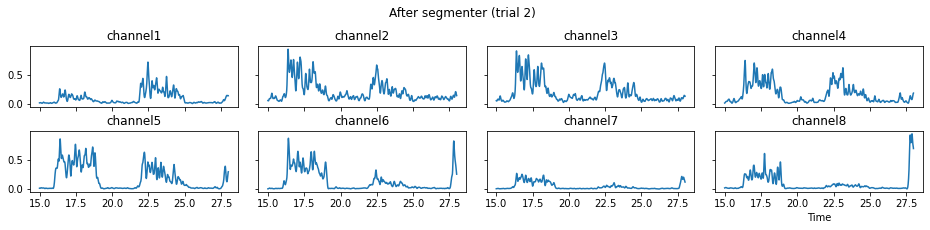

In [18]:
c = mgr.process_all(is_plot_processing_chain=True, k_for_plot=1)

The processed results from method *process_all* is saved in *c* of type
[EMGMeasurementCollection](https://aalhossary.github.io/pyemgpipeline/api/pyemgpipeline.wrappers.html#emgmeasurementcollection),
which possesses methods *plot*, *export_csv*, and the indexing operator [ ] for furtuer use.

In [19]:
isinstance(c, pep.wrappers.EMGMeasurementCollection)

True